# Diffusion Models in Depth - Implementation of a diffusion model for CIFAR-10 using PyTorch

Necessary imports

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import scipy

from PIL import Image

from utils import utils

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")           # GPU
elif torch.backends.mps.is_available():     
    device = torch.device("mps")            # Metal (for M-series Macs)
else:
    device = torch.device("cpu")            # CPU

print(f"Using device: {device}")

Using device: mps


Files already downloaded and verified


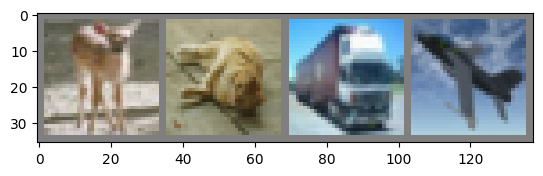

In [82]:
torch.random.manual_seed(0)
np.random.seed(0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)

data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

features, labels = next(iter(data_loader))
img = torchvision.utils.make_grid(features)

img = img.permute(1, 2, 0)
img = img / 2 + 0.5
plt.imshow(img)

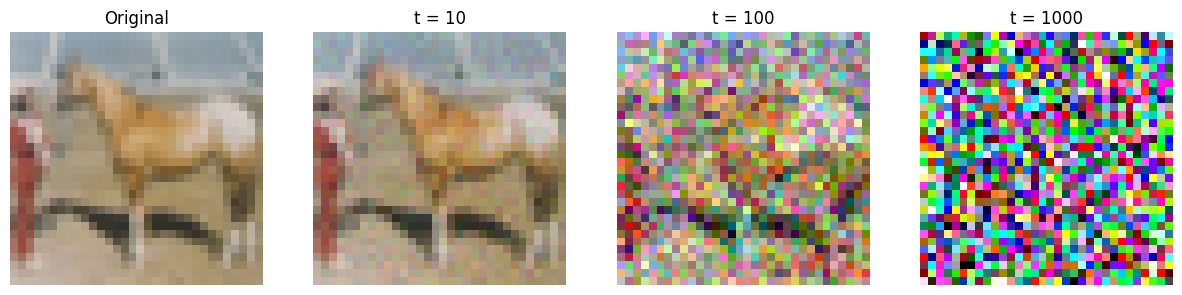

In [85]:
beta_linear_schedule = np.linspace(10**(-4), 0.02, 1000)

def forward(x_0, beta_schedule, t):

    # Compute the alpha schedule
    alpha_schedule = 1 - beta_schedule
    alpha_prod = np.cumprod(alpha_schedule)

    # Convert the input to a 1D numpy array
    x_0_copy = x_0.clone().numpy().flatten()

    # Compute the mean and std
    mean = np.sqrt(alpha_prod[t]) * x_0_copy
    std = (1 - alpha_prod[t]) * np.eye(x_0.numpy().size)

    # Sample from the multivariate normal distribution and return a tensor
    x_t = torch.from_numpy(np.random.multivariate_normal(mean, std)).reshape(x_0.shape)

    return x_t

def show_forward_process(x_0, steps: list):

    # Create a figure with subplots
    fig, ax = plt.subplots(1, len(steps) + 1, figsize=(15, 5))

    # Show the original image
    ax[0].imshow((x_0[0].permute(1, 2, 0)) / 2 + 0.5)
    ax[0].axis("off")
    ax[0].set_title("Original")

    for i, t in enumerate(steps):
        x_t = forward(x_0, beta_linear_schedule, t-1)
        x_t = x_t[0].permute(1, 2, 0)
        x_t = x_t / 2 + 0.5
        x_t = np.clip(x_t, 0, 1)
        ax[i + 1].axis("off")
        ax[i + 1].imshow(x_t)
        ax[i + 1].set_title(f"t = {t}")
    plt.show()

# Pick a random image from the dataset
img = (dataset[np.random.randint(0, len(dataset))][0]).unsqueeze(0)

# Show the forward process
show_forward_process(img, [10, 100, 1000])
